# Libs & Util

In [1]:
# Extracting Features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import noisereduce as nr
import IPython
from tqdm.notebook import tqdm
import json

# Training neural networks
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Live detection
import pyaudio
from IPython.display import clear_output
import wave

# ms per chunk
STEP = 50
PATH = "whistle_dataset/"

Using TensorFlow backend.
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Extracting features

## Chunk processor

>The chunk processor will get a sample with a feature type, and will utilize these to process said chunk into features. The chunk processor is used in both featurizers.

In [2]:
#def chunk_processor(sample, sample_rate, feature_type, target, false_window = 1, true_window= 1/50):
#def chunk_processor(sample, sample_rate, feature_type, target, false_window = 10, true_window= 1/5):
def chunk_processor(sample, sample_rate, feature_type, target, false_window = 25, true_window= 1/2):
    
    # get correct window variable
    if target:
        window = true_window
    else:
        window = false_window
        
    # calculate chunk size
    chunk = int((sample_rate / 1000) * STEP)
    
    # iterate over sample and fetch features
    for i in tqdm(range(0, len(sample) - chunk, int(chunk * window)), leave=False):
        if feature_type == "fft":
            chunk_features = np.mean(np.abs(librosa.stft(sample[i:i+chunk], n_fft=512, hop_length=256, win_length=512)).T, axis=0)
        elif feature_type == "mfcc":
            chunk_features = np.mean(librosa.feature.mfcc(y=sample[i:i+chunk], sr=sample_rate, n_mfcc=40).T, axis=0)
        
        try:
            features = np.append(features, np.array([chunk_features]), axis=0)
        except:
            features = np.array([chunk_features])
            
    return features, np.full(len(features), int(target))

## Featurizer V1

> Featurizer 1 only uses the whistle, and the segments before and after (same length). This is how a 2:1 label ratio is managed. Sequential samples also have 50% overlap.

In [3]:
# old windows were 1/5
def build_feature_dataframe_v1(feature_type, denoise=False):
    """Convert all whistles and small fragments before and after said whistles into features"""
    
    # See if csv has been calculated before (saving time)
    try:
        df = pd.read_csv("data_v1_" + feature_type + "_" + str(denoise) + ".csv", index_col=0)
        print("Dataframe succesfully loaded from csv!")
        return df
    except:
        pass
    
    # get the labels
    target = []
    with open(PATH + "whistledb.json") as json_file:
        labels = json.load(json_file)["audioFiles"]
        labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
    
    # iterate over all audiofiles
    for file_name in tqdm(os.listdir(PATH)):
        # skip json file
        if file_name.split(".")[-1] != "wav":
            continue

        # load file & meta data
        sample, sample_rate = librosa.load(PATH + file_name, sr=None)
        if denoise == True:
            sample = nr.reduce_noise(y=sample,  y_noise=sample[0:5000], sr=sample_rate)

        # for all positive intervals get part before and after aswell and featurize
        for times in tqdm(labels[file_name], leave=False):
            delta_time = times["end"] - times["start"]
            
            label = False
            for i in range(times["start"]-delta_time, times["end"]+delta_time, delta_time):
                if i >= 0 and i + delta_time <= len(sample):
                    features, targets = chunk_processor(sample[i:i+delta_time], sample_rate, feature_type, label, 
                                                        false_window = 1/2, true_window= 1/2)
                    label = not(label)
                    try:
                        out = np.append(out, features, axis=0)
                        target = np.append(target, targets)
                    except:
                        out = features
                        target = targets
                else:
                    print(file_name, i, 'no fit ;(')

    # save them in dataframe
    df = pd.DataFrame(out)
    df=(df-df.min())/(df.max()-df.min())
    df.insert(0, "target", target)
    df.to_csv("data_v1_" + feature_type + "_" + str(denoise) + ".csv")
    return df

## Featurizer V2

> Featurizer 2 utilises two different overlap values. True labels have 1/2 overlap, meaning that sequential samples have 50% overlap. False labels have a overlap value of 25, meaning that after each sample taken 24 are skipped. This insures that a 2:1 label ratio is kept while still taking a more fair representation of the dataset.

In [4]:
def build_feature_dataframe_v2(feature_type, denoise=False):
    
    # See if csv has been calculated before (saving time)
    try:
        df = pd.read_csv("data_v2_" + feature_type + "_" + str(denoise) + ".csv", index_col=0)
        print("Dataframe succesfully loaded from csv!")
        return df
    except:
        pass
    
    # get the labels
    target = []
    with open(PATH + "whistledb.json") as json_file:
        labels = json.load(json_file)["audioFiles"]
        labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
    
    # iterate over all audiofiles
    for file_name in tqdm(os.listdir(PATH)):
        # skip json file
        if file_name.split(".")[-1] != "wav":
            continue

        # load file & meta data
        sample, sample_rate = librosa.load(PATH + file_name, sr=None)
        if denoise == True:
            sample = nr.reduce_noise(y=sample,  y_noise=sample[0:5000], sr=sample_rate)
        
        # create time intervals
        times_list = [0]
        for times in labels[file_name]:
            times_list += [times["start"], times["end"]]
        if times_list[-1] < len(sample):
            times_list.append(len(sample))
        
        label = False
        for i in tqdm(range(len(times_list)-1), leave=False):
            features, targets = chunk_processor(sample[times_list[i]:times_list[i+1]], sample_rate, feature_type, label)
            label = not(label)
            try:
                out = np.append(out, features, axis=0)
                target = np.append(target, targets)
            except:
                out = features
                target = targets

    # save them in dataframe
    df = pd.DataFrame(out)
    df=(df-df.min())/(df.max()-df.min())
    df.insert(0, "target", target)
    df.to_csv("data_v2_" + feature_type + "_" + str(denoise) + ".csv")
    return df

In [5]:
def build_features(version, feature_type, denoise):
    if version == 1:
        return build_feature_dataframe_v1(feature_type, denoise)
    elif version == 2:
        return build_feature_dataframe_v2(feature_type, denoise)
    else:
        print("invalid version")

In [6]:
mass_data = build_features(1, "mfcc", False)
print("True label ratio:", round((len(mass_data[mass_data["target"] == 1]) / len(mass_data["target"])) * 100, 1),"%")

Dataframe succesfully loaded from csv!
True label ratio: 33.5 %


## Dataset debugging

> The following code allows for any whistle sample to be extracted in order to check if they are labeled correctly.

In [7]:
# Choose recording
i = -1
fname = os.listdir(PATH)[i]
print(fname)

with open(PATH + "whistledb.json") as json_file:
    labels = json.load(json_file)["audioFiles"]
    labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
print(labels[fname], len(labels[fname]))

sample_tts, sr = librosa.load(PATH + fname, sr=None)

WhistleTest_tuhhnao16.wav
[{'start': 14930000, 'end': 14970000}, {'start': 19186000, 'end': 19250000}, {'start': 19840000, 'end': 19930000}, {'start': 20339000, 'end': 20400000}, {'start': 20918000, 'end': 20955000}, {'start': 21082000, 'end': 21140000}, {'start': 21463000, 'end': 21520000}, {'start': 23044000, 'end': 23110000}, {'start': 23676000, 'end': 23730000}, {'start': 24353000, 'end': 24410000}, {'start': 27023000, 'end': 27060000}, {'start': 27830000, 'end': 27880000}, {'start': 28075000, 'end': 28116000}] 13


In [8]:
# Choose whistle number
i = -1
print(os.listdir(PATH))
print(labels[fname][i]["start"],labels[fname][i]["end"])

IPython.display.Audio(sample_tts[labels[fname][i]["start"]:labels[fname][i]["end"]], rate=sr)

['HTWK_Dutch_05_04_2017-2.wav', 'HTWK_Dutch_05_04_2017.wav', 'HTWK_HULKs_1930_2016_04_29.wav', 'Lab_Fox40_vs_printed.wav', 'LUnitedvsUPenn20170728.wav', 'LUnitedvsUPenn20170728Half2.wav', 'SRC_Dutch_05-04-2017.wav', 'TestBHuman_03_05_2017_1413.wav', 'whistledb.json', 'WhistleTest_tuhhnao12.wav', 'WhistleTest_tuhhnao16.wav']
28075000 28116000


# Training neural networks

## Support functions

In [9]:
# Randomise and split dataframe into X and Y
def feature_target_split(df, shuffle=True):
    if shuffle:
        df = df.sample(frac = 1)
    
    dataset = df.values
    X = dataset[:,1:].astype(float)
    
    Y = dataset[:,0]
    encoder = sklearn.preprocessing.LabelEncoder()
    encoder.fit(Y)
    Y = encoder.transform(Y)
    
    return X, Y

## Neural networks

In [10]:
def two_layer_integrated(X):
    inputs = Input(shape= (X.shape[1],))
    layer = Dense(128, activation="relu")(inputs)
    outputs = Dense(1, activation="sigmoid")(layer)
    model = Model(inputs, outputs)
    model.compile(loss = "binary_crossentropy",optimizer = "adam",metrics = ["acc"])
    mc = ModelCheckpoint("best_model_whistle.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    return model, mc

## Fitting network

Dataframe succesfully loaded from csv!
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 4763 samples, validate on 1191 samples
Epoch 1/500
4763/4763 [==============================] - 0s 40us/step - loss: 0.5174 - acc: 0.7499 - val_loss: 0.3710 - val_acc: 0.9043

Epoch 00001: val_loss improved from inf to 0.37096, saving model to best_model_whistle.hdf5
Epoch 2/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.3096 - acc: 0.8963 - val_loss: 0.2246 - val_acc: 0.9270

Epoch 00002: val_loss improved from 0.37096 to 0.22456, saving model to best_model_whistle.hdf5
Epoch 3/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.2154 - acc: 0.9309 - val_loss: 0.1724 - val_acc: 0.9379

Epoch 00003: val_loss improved from 0.22456 to 0.17244, saving model to best_model_whistle.hdf5
Epoch 4/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.1740 - acc: 0.9429 - val_loss: 0.1530 - val


Epoch 00035: val_loss improved from 0.08398 to 0.08264, saving model to best_model_whistle.hdf5
Epoch 36/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0634 - acc: 0.9798 - val_loss: 0.0933 - val_acc: 0.9757

Epoch 00036: val_loss did not improve from 0.08264
Epoch 37/500
4763/4763 [==============================] - 0s 21us/step - loss: 0.0635 - acc: 0.9792 - val_loss: 0.0834 - val_acc: 0.9715

Epoch 00037: val_loss did not improve from 0.08264
Epoch 38/500
4763/4763 [==============================] - 0s 21us/step - loss: 0.0635 - acc: 0.9784 - val_loss: 0.0877 - val_acc: 0.9765

Epoch 00038: val_loss did not improve from 0.08264
Epoch 39/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0639 - acc: 0.9794 - val_loss: 0.0834 - val_acc: 0.9757

Epoch 00039: val_loss did not improve from 0.08264
Epoch 40/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0614 - acc: 0.9805 - val_loss: 0.0913 - val_acc: 0.9757

Epoch 000

4763/4763 [==============================] - 0s 18us/step - loss: 0.0499 - acc: 0.9828 - val_loss: 0.0794 - val_acc: 0.9773

Epoch 00076: val_loss did not improve from 0.07815
Epoch 77/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0490 - acc: 0.9840 - val_loss: 0.0869 - val_acc: 0.9765

Epoch 00077: val_loss did not improve from 0.07815
Epoch 78/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0511 - acc: 0.9811 - val_loss: 0.0796 - val_acc: 0.9765

Epoch 00078: val_loss did not improve from 0.07815
Epoch 79/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0490 - acc: 0.9828 - val_loss: 0.0898 - val_acc: 0.9748

Epoch 00079: val_loss did not improve from 0.07815
Epoch 80/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0502 - acc: 0.9840 - val_loss: 0.0863 - val_acc: 0.9757

Epoch 00080: val_loss did not improve from 0.07815
Epoch 81/500
4763/4763 [==============================] - 0s 19us/st

4763/4763 [==============================] - 0s 19us/step - loss: 0.0447 - acc: 0.9855 - val_loss: 0.0811 - val_acc: 0.9773

Epoch 00118: val_loss did not improve from 0.07505
Epoch 119/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0453 - acc: 0.9838 - val_loss: 0.0772 - val_acc: 0.9757

Epoch 00119: val_loss did not improve from 0.07505
Epoch 120/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0444 - acc: 0.9847 - val_loss: 0.0812 - val_acc: 0.9773

Epoch 00120: val_loss did not improve from 0.07505
Epoch 121/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0449 - acc: 0.9851 - val_loss: 0.0756 - val_acc: 0.9773

Epoch 00121: val_loss did not improve from 0.07505
Epoch 122/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0418 - acc: 0.9866 - val_loss: 0.0750 - val_acc: 0.9782

Epoch 00122: val_loss improved from 0.07505 to 0.07502, saving model to best_model_whistle.hdf5
Epoch 123/500
4763/

4763/4763 [==============================] - 0s 23us/step - loss: 0.0400 - acc: 0.9861 - val_loss: 0.0783 - val_acc: 0.9765

Epoch 00160: val_loss did not improve from 0.07392
Epoch 161/500
4763/4763 [==============================] - 0s 21us/step - loss: 0.0400 - acc: 0.9866 - val_loss: 0.0761 - val_acc: 0.9773

Epoch 00161: val_loss did not improve from 0.07392
Epoch 162/500
4763/4763 [==============================] - 0s 22us/step - loss: 0.0385 - acc: 0.9880 - val_loss: 0.0854 - val_acc: 0.9757

Epoch 00162: val_loss did not improve from 0.07392
Epoch 163/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0426 - acc: 0.9859 - val_loss: 0.0761 - val_acc: 0.9790

Epoch 00163: val_loss did not improve from 0.07392
Epoch 164/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0388 - acc: 0.9889 - val_loss: 0.0736 - val_acc: 0.9782

Epoch 00164: val_loss improved from 0.07392 to 0.07359, saving model to best_model_whistle.hdf5
Epoch 165/500
4763/

4763/4763 [==============================] - 0s 18us/step - loss: 0.0324 - acc: 0.9885 - val_loss: 0.0774 - val_acc: 0.9773

Epoch 00202: val_loss did not improve from 0.07092
Epoch 203/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0340 - acc: 0.9885 - val_loss: 0.0702 - val_acc: 0.9807

Epoch 00203: val_loss improved from 0.07092 to 0.07025, saving model to best_model_whistle.hdf5
Epoch 204/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0339 - acc: 0.9885 - val_loss: 0.0712 - val_acc: 0.9782

Epoch 00204: val_loss did not improve from 0.07025
Epoch 205/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0328 - acc: 0.9889 - val_loss: 0.0828 - val_acc: 0.9765

Epoch 00205: val_loss did not improve from 0.07025
Epoch 206/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0334 - acc: 0.9899 - val_loss: 0.0719 - val_acc: 0.9798

Epoch 00206: val_loss did not improve from 0.07025
Epoch 207/500
4763/


Epoch 00244: val_loss did not improve from 0.06904
Epoch 245/500
4763/4763 [==============================] - 0s 20us/step - loss: 0.0300 - acc: 0.9903 - val_loss: 0.1222 - val_acc: 0.9706

Epoch 00245: val_loss did not improve from 0.06904
Epoch 246/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0282 - acc: 0.9893 - val_loss: 0.0733 - val_acc: 0.9790

Epoch 00246: val_loss did not improve from 0.06904
Epoch 247/500
4763/4763 [==============================] - 0s 20us/step - loss: 0.0291 - acc: 0.9908 - val_loss: 0.0810 - val_acc: 0.9798

Epoch 00247: val_loss did not improve from 0.06904
Epoch 248/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0301 - acc: 0.9891 - val_loss: 0.0708 - val_acc: 0.9798

Epoch 00248: val_loss did not improve from 0.06904
Epoch 249/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0278 - acc: 0.9908 - val_loss: 0.0816 - val_acc: 0.9765

Epoch 00249: val_loss did not improve from 0.0690

4763/4763 [==============================] - 0s 18us/step - loss: 0.0230 - acc: 0.9920 - val_loss: 0.0714 - val_acc: 0.9815

Epoch 00287: val_loss did not improve from 0.06855
Epoch 288/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0257 - acc: 0.9916 - val_loss: 0.0826 - val_acc: 0.9757

Epoch 00288: val_loss did not improve from 0.06855
Epoch 289/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0235 - acc: 0.9927 - val_loss: 0.0702 - val_acc: 0.9790

Epoch 00289: val_loss did not improve from 0.06855
Epoch 290/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0231 - acc: 0.9933 - val_loss: 0.0736 - val_acc: 0.9815

Epoch 00290: val_loss did not improve from 0.06855
Epoch 291/500
4763/4763 [==============================] - 0s 22us/step - loss: 0.0252 - acc: 0.9927 - val_loss: 0.0841 - val_acc: 0.9773

Epoch 00291: val_loss did not improve from 0.06855
Epoch 292/500
4763/4763 [==============================] - 0s 22

4763/4763 [==============================] - 0s 18us/step - loss: 0.0197 - acc: 0.9929 - val_loss: 0.0939 - val_acc: 0.9757

Epoch 00330: val_loss did not improve from 0.06855
Epoch 331/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0205 - acc: 0.9939 - val_loss: 0.0897 - val_acc: 0.9782

Epoch 00331: val_loss did not improve from 0.06855
Epoch 332/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0199 - acc: 0.9931 - val_loss: 0.0896 - val_acc: 0.9773

Epoch 00332: val_loss did not improve from 0.06855
Epoch 333/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0195 - acc: 0.9937 - val_loss: 0.1045 - val_acc: 0.9748

Epoch 00333: val_loss did not improve from 0.06855
Epoch 334/500
4763/4763 [==============================] - 0s 20us/step - loss: 0.0216 - acc: 0.9920 - val_loss: 0.0764 - val_acc: 0.9798

Epoch 00334: val_loss did not improve from 0.06855
Epoch 335/500
4763/4763 [==============================] - 0s 20

4763/4763 [==============================] - 0s 24us/step - loss: 0.0159 - acc: 0.9950 - val_loss: 0.0888 - val_acc: 0.9782

Epoch 00373: val_loss did not improve from 0.06855
Epoch 374/500
4763/4763 [==============================] - 0s 23us/step - loss: 0.0160 - acc: 0.9956 - val_loss: 0.1051 - val_acc: 0.9740

Epoch 00374: val_loss did not improve from 0.06855
Epoch 375/500
4763/4763 [==============================] - 0s 20us/step - loss: 0.0182 - acc: 0.9935 - val_loss: 0.0795 - val_acc: 0.9773

Epoch 00375: val_loss did not improve from 0.06855
Epoch 376/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0162 - acc: 0.9952 - val_loss: 0.0781 - val_acc: 0.9798

Epoch 00376: val_loss did not improve from 0.06855
Epoch 377/500
4763/4763 [==============================] - 0s 20us/step - loss: 0.0170 - acc: 0.9943 - val_loss: 0.0811 - val_acc: 0.9807

Epoch 00377: val_loss did not improve from 0.06855
Epoch 378/500
4763/4763 [==============================] - 0s 20

4763/4763 [==============================] - 0s 21us/step - loss: 0.0166 - acc: 0.9943 - val_loss: 0.0915 - val_acc: 0.9773

Epoch 00416: val_loss did not improve from 0.06855
Epoch 417/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0145 - acc: 0.9952 - val_loss: 0.0823 - val_acc: 0.9807

Epoch 00417: val_loss did not improve from 0.06855
Epoch 418/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0133 - acc: 0.9962 - val_loss: 0.0761 - val_acc: 0.9790

Epoch 00418: val_loss did not improve from 0.06855
Epoch 419/500
4763/4763 [==============================] - 0s 19us/step - loss: 0.0124 - acc: 0.9973 - val_loss: 0.0927 - val_acc: 0.9773

Epoch 00419: val_loss did not improve from 0.06855
Epoch 420/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0139 - acc: 0.9960 - val_loss: 0.0893 - val_acc: 0.9782

Epoch 00420: val_loss did not improve from 0.06855
Epoch 421/500
4763/4763 [==============================] - 0s 19

4763/4763 [==============================] - 0s 20us/step - loss: 0.0161 - acc: 0.9939 - val_loss: 0.0980 - val_acc: 0.9782

Epoch 00459: val_loss did not improve from 0.06855
Epoch 460/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0109 - acc: 0.9973 - val_loss: 0.0913 - val_acc: 0.9807

Epoch 00460: val_loss did not improve from 0.06855
Epoch 461/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0106 - acc: 0.9973 - val_loss: 0.0874 - val_acc: 0.9807

Epoch 00461: val_loss did not improve from 0.06855
Epoch 462/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0127 - acc: 0.9969 - val_loss: 0.0948 - val_acc: 0.9790

Epoch 00462: val_loss did not improve from 0.06855
Epoch 463/500
4763/4763 [==============================] - 0s 18us/step - loss: 0.0105 - acc: 0.9969 - val_loss: 0.0846 - val_acc: 0.9790

Epoch 00463: val_loss did not improve from 0.06855
Epoch 464/500
4763/4763 [==============================] - 0s 18

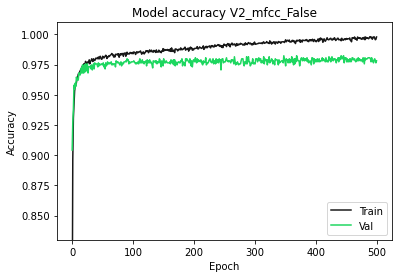

In [11]:
def train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise, plot=False):
    
    # model training
    model, model_checkpoint = two_layer_integrated(X_train)
    history = model.fit(X_train, Y_train ,epochs=500, callbacks=[model_checkpoint], batch_size=32, 
                        validation_data=(X_test, Y_test))

    # load the best model weights
    model.load_weights('best_model_whistle.hdf5')
    
    # save model
    model.save("model_v" + str(version) + "_" + feature_type + "_" + str(denoise) + ".h5")

    # summarize history for loss
    if plot:
        plt.plot(history.history["acc"], c="#181818")
        plt.plot(history.history["val_acc"], c="#1ED760")
        plt.title("Model accuracy V" + str(version) + "_" + feature_type + "_" + str(denoise))
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Val"], loc="lower right")
        plt.ylim([0.83,1.01])
        plt.show()
        
    return model

def train_model(version, feature_type, denoise):
    # load data
    mass_data = build_features(version, feature_type, denoise)
    
    # train test split
    X, Y = feature_target_split(mass_data)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, 
                                                        random_state=12, shuffle=True)
    
    return X_test, Y_test, train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise, plot=True)
        

X_test, Y_test, model = train_model(2, "mfcc", False)

## Confusion Matrix

acc: 0.9773299694061279


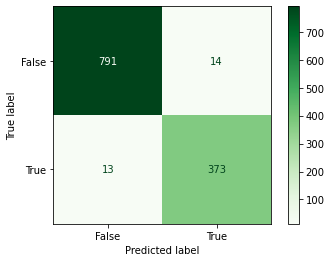

In [12]:
cm = confusion_matrix(Y_test, [1 if prediction > .5 else 0 for prediction in model.predict(X_test)[:,0]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
print("acc:", model.evaluate(X_test, Y_test, verbose=0)[1])
disp.plot(cmap="Greens")

## PCA Decomposition

Dataframe succesfully loaded from csv!


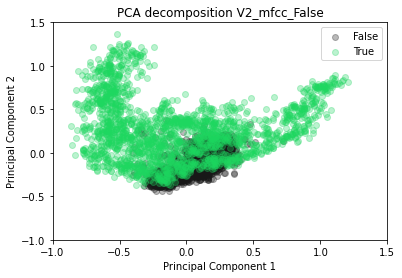

In [13]:
def pca_decompose(version, feature_type, denoise):
    # load data
    df = build_features(version, feature_type, denoise)
    
    # pca decomposition
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df.loc[:, df.columns != "target"])
    pca_df = pd.DataFrame(data = principalComponents, columns = ["dim_1", "dim_2"])
    pca_df.insert (0, "target", df["target"])
    
    # plot
    colors = ["#181818", "#1ED760"]
    for i, label in enumerate(pca_df["target"].unique()):
        pca_label = pca_df[pca_df["target"] == label]
        plt.scatter(pca_label["dim_1"], pca_label["dim_2"], label = bool(label), alpha=0.3, c = colors[i])
    plt.title("PCA decomposition V" + str(version) + "_" + feature_type + "_" + str(denoise))
    plt.xlim([-1,1.5])
    plt.ylim([-1,1.5])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    
pca_decompose(2, "mfcc", False)

## K-fold validation

In [14]:
# Kfold implementation, written by Paul Boersma
def kfold_index(df, k=5):
    N = len(df)
    minimum_number_of_points_per_slice = N // k
    remaining_number_of_points = N % k
    starting_point = 0
    out = []
    for islice in range(0, k):
        end_point = starting_point + minimum_number_of_points_per_slice + ( islice < remaining_number_of_points )
        out.append((starting_point, end_point))
        starting_point = end_point
    return out

# Run kfold for given featureset
def execute_kfold(version, feature_type, denoise, k=5):
    acc_train = []
    acc_test = []
    cm = np.zeros((2,2))
    df = build_features(version, feature_type, denoise)
    X, Y = feature_target_split(df)
    for start, end in kfold_index(df, k):
        X_train = np.concatenate((X[:start], X[end:]))
        Y_train = np.concatenate((Y[:start], Y[end:]))
        X_test = X[start:end]
        Y_test = Y[start:end]
        
        model = train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise)
        acc_train.append(model.evaluate(X_train, Y_train, verbose=0)[1])
        acc_test.append(model.evaluate(X_test, Y_test, verbose=0)[1])
        cm += confusion_matrix(Y_test, [1 if prediction > .5 else 0 for prediction in model.predict(X_test)[:,0]])
        
    print('Accuracy on train data:', acc_train, np.mean(acc_train))
    print('Accuracy on test data:', acc_test, np.mean(acc_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
    disp.plot(cmap="Greens", values_format='')

#execute_kfold(1, 'fft', False)

# Live detection

In [15]:
# constants
FORMAT = pyaudio.paFloat32      # audio format (bytes per sample?)
CHANNELS = 1                    # single channel for microphone
SR = 48000                      # samples per second
CHUNK = int((SR / 1000) * STEP) # chunk size
WAVE_OUTPUT_FILENAME = "file.wav"

In [16]:
def live_detect(feature_type, version, denoise, record_seconds=15, write=False):
    # load model
    try:
        model = load_model("model_v" + str(version) + "_" + feature_type + "_" + str(denoise) + ".h5")
    except:
        _, _, model = train_model(version, feature_type, denoise)
    
    # pyaudio class instance
    p = pyaudio.PyAudio()
    buffer = [False] * 10

    # stream object to get data from microphone
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=SR,
        input=True,
        output=True,
        frames_per_buffer=CHUNK
    )

    print("recording...")
    frames = []

    for i in range(0, int(SR / CHUNK * record_seconds)):
        # read chunk
        data = stream.read(CHUNK)
        frames.append(data)
        
        # fetch features
        sample = np.frombuffer(data, dtype=np.float32)
        if feature_type == "fft":
            features = np.mean(np.abs(librosa.stft(sample, n_fft=512, hop_length=256, win_length=512)).T, axis=0)
        elif feature_type == "mfcc":
            features = np.mean(librosa.feature.mfcc(y=sample, sr=SR, n_mfcc=40).T, axis=0)
        
        # make prediction
        features = np.expand_dims(features, axis=0)
        is_whistle = model.predict(features, verbose=0)[0][0]
        
        # print current certainty
        buffer.pop(0)
        buffer.append(is_whistle > .5)
        clear_output(wait=True)
        print("whistle likelihood:", str((sum(buffer)/len(buffer)) * 100) + "%")
        
        
    print("finished recording")

    # stop recording
    stream.stop_stream()
    stream.close()
    p.terminate()

    # write to file
    if write:       
        waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
        waveFile.setnchannels(CHANNELS)
        waveFile.setsampwidth(p.get_sample_size(FORMAT))
        waveFile.setframerate(SR)
        waveFile.writeframes(b''.join(frames))
        waveFile.close()
        
live_detect("mfcc", 2, False, write=False)

whistle likelihood: 100.0%
finished recording
